<a href="https://github.com/EmmanuelADAM/IntelligenceArtificiellePython/blob/master/TPClassificationLivres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
---
# Classification de commentaires de livres (en français)

## Auteur : Mathis Crinchon M1 TNSID 

## Collection de données de critiques de films 
Le tp utilisera l'ensemble de données issues de 
[French Book reviews](https://www.kaggle.com/datasets/abireltaief/books-reviews) que vous devez télécharger.

Ce fichier CSV contient presque 10000 commentaires sur des livres, leurs notes, et l'avis (positif, négatif ou neutre).

---
Vous vous baserez sur la solution à *[Détection de "sentiments"](https://github.com/EmmanuelADAM/IntelligenceArtificiellePython/blob/master/SolutionTPDetectionDeSentiments.ipynb)*.

Vous adapterez le code présent pour traiter le texte en français.
Simpement, les "stopwords" seront chargés ainsi : 

In [269]:
%pip install pandas
%pip install tqdm
%pip install nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [270]:
##import pour les fichiers et le traitement de données : 
from os import listdir
import pandas as pd
from tqdm import tqdm

##import pour la creation de tokens
import nltk
from nltk.corpus import stopwords

##import pour la gestion de ponctuation
from string import punctuation

##import pour une collection spécifique : counter
from collections import Counter

##import pour les réseaux de neurones : 
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import preprocessing

##import classique pour les tableaux efficaces
import numpy as np

nltk.download("stopwords")
stop_words = set(stopwords.words('french'))
print(stop_words)

{'leur', 'étés', 'le', 'ces', 'du', 'aient', 'ma', 'eue', 'fût', 'les', 'étant', 'soient', 'fusse', 'auriez', 'ayez', 'aura', 'seront', 'eues', 'ta', 'avais', 'étions', 'ont', 'serions', 'eurent', 'seraient', 'tes', 'aurais', 'aviez', 'eus', 'auras', 'sa', 'étiez', 'aurait', 'eussions', 'ses', 'elle', 'on', 'mes', 'fusses', 'm', 'eûtes', 'aie', 'sommes', 'ait', 'j', 'des', 'fussions', 'au', 'pas', 'ton', 'tu', 'serai', 'eux', 'est', 'aurez', 'avons', 'as', 'il', 'ils', 'eu', 'et', 'lui', 'dans', 'serez', 'votre', 'aurai', 'mais', 'y', 's', 'soyez', 'avez', 'son', 'la', 'fussiez', 'étants', 'étante', 'serait', 'eut', 'de', 'toi', 'ayante', 'aurions', 'ou', 'ce', 'te', 'c', 'que', 'n', 'eûmes', 'ne', 'aies', 't', 'je', 'ai', 'seriez', 'à', 'sois', 'vous', 'était', 'd', 'l', 'vos', 'nos', 'eusses', 'serons', 'une', 'sur', 'ayons', 'fûmes', 'aux', 'ayants', 'eussent', 'furent', 'eussiez', 'aurons', 'étais', 'notre', 'par', 'moi', 'étantes', 'fussent', 'ayantes', 'qui', 'seras', 'eût', 'ava

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mathis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [271]:
def clean_doc(doc:str)->list:
    """retourne la liste de mots clés inclus dans le texte doc 
    qui ne font pas parti des stop_words"""
    # split into tokens by white space
    tokens = doc.split()
    # remove punctuation from each token
    table = str.maketrans(' ', ' ', punctuation)
    tokens = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word.lower() for word in tokens if word.isalpha()]
    # filter out stop words
    tokens = [w for w in tokens if not w in stop_words]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 2]
    return tokens

In [272]:
#quelques types, optionels, juste pour un beau code
Series = pd.core.series.Series
DataFrame = pd.core.frame.DataFrame

In [273]:
#rep = '/content/drive/My Drive/txt_sentoken'
rep:str = "C:/Users/Mathis/Documents/Cours/M1/IA_Raisonnement/TP/TP2/"
# mots clés d'un fichier négatif
filename:str = "french_books_reviews.csv"
datas:DataFrame = pd.read_csv("C:/Users/Mathis/Documents/Cours/M1/IA_Raisonnement/TP/TP2/french_books_reviews.csv")
reviews:Series = datas['reader_review']

tokens:list = clean_doc(reviews[0])
print('les 10 premiers mots cles de ', reviews[0])
print(tokens[:10])

les 10 premiers mots cles de  日光流年, 阎连科. Le temps est à la fois une évidence et un mystère, de nombreux auteurs ont écrit sur ce sujet. Le roman de Yan Lianke raconte l’histoire des habitants du village des Trois Patronymes, perdu dans des montagnes d’une province chinoise. Les habitants doivent lutter pour survivre, mais ils sont tous emportés par la maladie de la gorge obstruée avant l’âge de 40 ans.
['日光流年', '阎连科', 'temps', 'fois', 'évidence', 'mystère', 'nombreux', 'auteurs', 'écrit', 'sujet']


In [274]:
def add_doc_to_vocab(review:str, vocab:Counter):
    """cumule dans la liste vocab les mots de la review 
    (1 seule occurence par mot dans vocab)"""
    # clean doc
    tokens = clean_doc(review)
    # update counts
    vocab.update(tokens)

def build_voc(serie:Series, vocab:Counter):
    """ajoute au dictionnaire vocab les mots cles de 90% de la serie de données"""
    i=0
    nb = int(serie.size)
    # walk through all files in the folder
    for i in tqdm(range(nb)):
        # add doc to vocab
        add_doc_to_vocab(serie[i], vocab)


In [275]:
# creer un vocabulaire (liste de mots clés associés à leurs occurences)
vocab:Counter = Counter()
build_voc(reviews, vocab)
# afficher le nb de mots cles trouves
print("nb de mots cles trouves dans les repertoires : ", len(vocab))
print("les 10 premiers mots cles du vocabulaire \
(et leur nb d\'apparition dans les exemples)  : \n", end='')
i:int=0
for (mot,count) in vocab.items(): 
    print(mot,':',count,end=", ")
    i = i+1
    if i>10:break
# afficher les 10 mots cles les plus utilises
print("\nles 10 mots cles les plus utilises : ", vocab.most_common(10))

 76%|███████▌  | 7333/9643 [00:00<00:00, 18034.25it/s]

100%|██████████| 9643/9643 [00:00<00:00, 17872.63it/s]

nb de mots cles trouves dans les repertoires :  36317
les 10 premiers mots cles du vocabulaire (et leur nb d'apparition dans les exemples)  : 
日光流年 : 1, 阎连科 : 1, temps : 635, fois : 611, évidence : 12, mystère : 75, nombreux : 110, auteurs : 96, écrit : 311, sujet : 207, roman : 2066, 
les 10 mots cles les plus utilises :  [('plus', 2430), ('livre', 2350), ('cette', 2220), ('tout', 2083), ('roman', 2066), ('bien', 1833), ('très', 1813), ('jai', 1726), ('cest', 1480), ('fait', 1335)]


In [276]:
# ne garder que les mots clés apparaissant au moins x fois
min_occurrence:int = 3
tokens:list = [token for (token,count) in vocab.items() if count >= min_occurrence]
print('en otant les mots utilise moins de ', min_occurrence, ' fois,', 
      ' nb de mots cles = ',len(tokens))

en otant les mots utilise moins de  3  fois,  nb de mots cles =  11937


In [277]:
def save_list(lines:list, filename:str):
    """sauve les mots de la liste de commentaires lines dans le fichier filename"""
    # convert lines to a single blob of text
    data = '\n'.join(lines)
    # open file
    file = open(filename, 'w')
    # write text
    file.write(data)
    # close file
    file.close()

# save tokens to a vocabulary file
save_list(tokens, rep+'vocab.txt')

In [278]:
def load_doc(filename:str)->str:
    """retourne le texte inclu dans le fichier filename"""
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [279]:
def vocab_in_doc(texte:str, vocab:list)->list:
    """retourne la liste des mots cles du texte qui appartenant au vocabulaire vocab"""
    # clean doc
    tokens = clean_doc(texte)
    # filter by vocab
    tokens = [token for token in tokens if token in vocab]
    return ' '.join(tokens)

In [280]:
def process_docs(serie:list, vocab:list)->list:
    """retourne une listes des mots cles des textes contenu dans la serie de texte"""
    lines = list()

    nb = int(serie.size*0.9)
    # walk through all files in the folder
    for i in tqdm(range(serie.size)):
        line = vocab_in_doc(serie[i], vocab)
        lines.append(line)
    return lines

In [281]:
# load the vocabulary
vocab_filename = 'vocab.txt'
vocab = load_doc(rep+vocab_filename)
vocab = vocab.split()
vocab = set(vocab)

In [282]:
# on ne garde qu'un peu de données pour tester les fonctionalités
# on prendra le tout si la preuve de concept a réussi
reviews = reviews[:20000]

In [283]:
# load training and testing reviews
lines_input:list = process_docs(reviews, vocab)
nb_input:int = len(lines_input)

# summarize what we have
print("nb exemples : ", nb_input)

100%|██████████| 9643/9643 [00:00<00:00, 18118.37it/s]

nb exemples :  9643


### Convertir les listes de mots en vecteur fréquence d'apparition 


In [284]:
# create the tokenizer
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(lines_input)
xTrain:np.ndarray = tokenizer.texts_to_matrix(lines_input, mode='freq')

In [285]:
print('Xtrain contient ', xTrain.shape[0], ' exemples de ', xTrain.shape[1], ' valeurs')
print('une valeur = fréquence d\'apparition des mots dans le vocabulaire global.')
print('Ainsi, premier exemple d\'entrainement = \n', xTrain[0])

Xtrain contient  9643  exemples de  11938  valeurs
une valeur = fréquence d'apparition des mots dans le vocabulaire global.
Ainsi, premier exemple d'entrainement = 
 [0. 0. 0. ... 0. 0. 0.]


In [286]:
#on ajoute+1 à toute les étiqettes pour que la range soit de 0 à 2 et non de -1 à 1
datas['label'] = datas['label'] + 1

---
A partir de la colonne 'reader_review' plusieurs classements sont possibles : 
- soit le classement de valeurs entre -1 et 1 (ce qui correspond à la colonne 'label')
- soit le classement par une note entre . et 5 (ce qui correspond à la colonne 'rating')

*N.B. la fonction d'activation sigmoid pren ses valeurs dans [0,1], l'activation en utilisant la tangente hyperboliquye 'tanh' prend ses valeus dans [-1, 1]*

In [287]:
#le nb de neurones en entrée (= nb de tokens retenus)
n_words = xTrain.shape[1] 

In [288]:
n_words

11938

# Réseau de neurone n°1 :

## Modèle classique

Epoch 1/7
18/18 - 24s - loss: 0.8363 - accuracy: 0.6717 - val_loss: 0.7599 - val_accuracy: 0.7005 - 24s/epoch - 1s/step
Epoch 2/7
18/18 - 12s - loss: 0.6163 - accuracy: 0.7426 - val_loss: 1.0349 - val_accuracy: 0.6373 - 12s/epoch - 675ms/step
Epoch 3/7
18/18 - 12s - loss: 0.3984 - accuracy: 0.8486 - val_loss: 1.5180 - val_accuracy: 0.5793 - 12s/epoch - 667ms/step
Epoch 4/7
18/18 - 11s - loss: 0.2209 - accuracy: 0.9295 - val_loss: 2.1464 - val_accuracy: 0.5751 - 11s/epoch - 606ms/step
Epoch 5/7
18/18 - 11s - loss: 0.1287 - accuracy: 0.9611 - val_loss: 2.8314 - val_accuracy: 0.5316 - 11s/epoch - 599ms/step
Epoch 6/7
18/18 - 11s - loss: 0.1032 - accuracy: 0.9697 - val_loss: 2.9709 - val_accuracy: 0.5927 - 11s/epoch - 638ms/step
Epoch 7/7
18/18 - 11s - loss: 0.0817 - accuracy: 0.9778 - val_loss: 3.0828 - val_accuracy: 0.5751 - 11s/epoch - 629ms/step


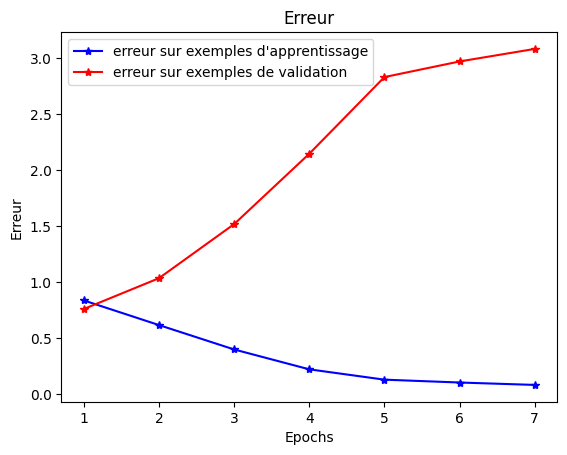

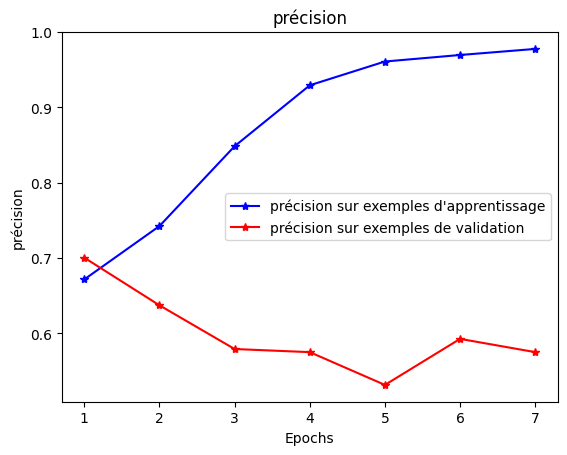

In [289]:
#  définir la structure du réseau
model = Sequential()
model.add(Dense(n_words//3, input_shape=(n_words,), activation='elu'))
model.add(Dense(n_words//27, activation='elu'))
model.add(Dense(n_words//243, activation='elu'))

#Trois sortie pour label(c'est -1, 0 ou 1)
model.add(Dense(3, activation='softmax'))
# compile network
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

#TODO tester differents nb de tests (epochs)
history = model.fit(xTrain, datas['label'], 
                    validation_split = 0.1,                    
#                    validation_data=(xTest, yTest),
                    batch_size=500,
#                    steps_per_epoch=10,
                    epochs=7, 
                    verbose=2)

history_dict = history.history
history_dict.keys()

import matplotlib.pyplot as plt

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, loss, 'b-*', label='erreur sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_loss, 'r-*', label='erreur sur exemples de validation')
plt.title('Erreur')
plt.xlabel('Epochs')
plt.ylabel('Erreur')
plt.legend()

plt.show()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, acc, 'b-*', label='précision sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_acc, 'r-*', label='précision sur exemples de validation')
plt.title('précision')
plt.xlabel('Epochs')
plt.ylabel('précision')
plt.legend()

plt.show()


Ce réseau de neuronne est en surapprentissage, peut être que sur un jeu de donnée plus grand ou avec de meilleur echantillon en apprentissage nous aurions un bon modèle

# Réseau de neurone n°2 :

## Pour eviter l'overfitting j'ajoute la régularisation et le dropout : 
La régularisation : La régularisation ajoute une pénalité à la complexité du modèle dans la fonction de perte, ce qui peut aider à prévenir le surapprentissage. Dans Keras, vous pouvez ajouter une régularisation L1 ou L2 à vos couches. 

Utiliser le dropout : Le dropout est une technique où certains neurones sont "éteints" pendant l'entraînement. Cela aide à prévenir le surapprentissage en forçant le réseau à apprendre des représentations redondantes des données.

Epoch 1/7
18/18 - 15s - loss: 25.1452 - accuracy: 0.6680 - val_loss: 3.8911 - val_accuracy: 0.7057 - 15s/epoch - 816ms/step
Epoch 2/7
18/18 - 14s - loss: 3.0136 - accuracy: 0.6885 - val_loss: 1.9124 - val_accuracy: 0.7057 - 14s/epoch - 777ms/step
Epoch 3/7
18/18 - 15s - loss: 1.3892 - accuracy: 0.6885 - val_loss: 1.0624 - val_accuracy: 0.7057 - 15s/epoch - 821ms/step
Epoch 4/7
18/18 - 15s - loss: 1.0311 - accuracy: 0.6885 - val_loss: 0.9081 - val_accuracy: 0.7057 - 15s/epoch - 815ms/step
Epoch 5/7
18/18 - 14s - loss: 0.9144 - accuracy: 0.6885 - val_loss: 0.8462 - val_accuracy: 0.7057 - 14s/epoch - 765ms/step
Epoch 6/7
18/18 - 12s - loss: 0.8753 - accuracy: 0.6885 - val_loss: 0.8123 - val_accuracy: 0.7057 - 12s/epoch - 681ms/step
Epoch 7/7
18/18 - 12s - loss: 0.8510 - accuracy: 0.6885 - val_loss: 0.8009 - val_accuracy: 0.7057 - 12s/epoch - 682ms/step


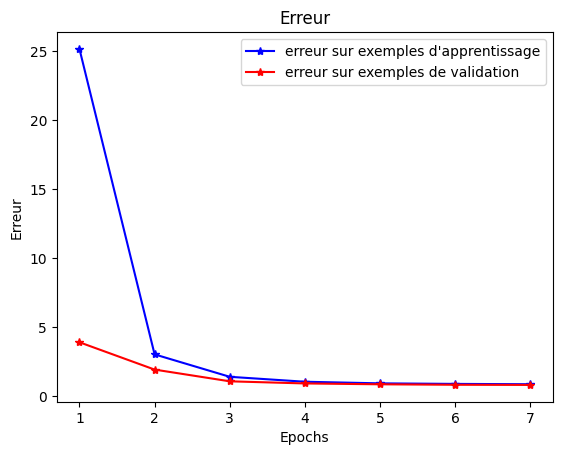

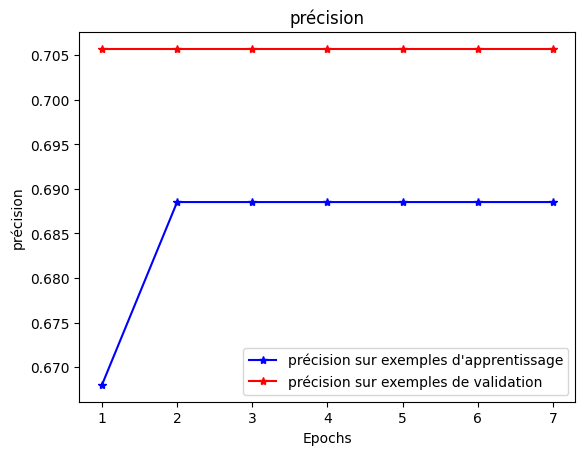

In [248]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
#
## On défini un dropout et une régularisation pour éviter l'overfitting
#  définir la structure du réseau
model = Sequential()
model.add(Dense(n_words//3, input_shape=(n_words,), activation='elu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(n_words//27, activation='elu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(n_words//243, activation='elu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

# compile network
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

#TODO tester differents nb de tests (epochs)
history = model.fit(xTrain, datas['label'], 
                    validation_split = 0.1,                    
#                    validation_data=(xTest, yTest),
                    batch_size=500,
#                    steps_per_epoch=10,
                    epochs=7, 
                    verbose=2)

history_dict = history.history
history_dict.keys()

import matplotlib.pyplot as plt

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, loss, 'b-*', label='erreur sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_loss, 'r-*', label='erreur sur exemples de validation')
plt.title('Erreur')
plt.xlabel('Epochs')
plt.ylabel('Erreur')
plt.legend()

plt.show()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, acc, 'b-*', label='précision sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_acc, 'r-*', label='précision sur exemples de validation')
plt.title('précision')
plt.xlabel('Epochs')
plt.ylabel('précision')
plt.legend()

plt.show()

# Réseau de neurone n°3 :
Ajout de nouvelles couches de neuronne

Epoch 1/7
18/18 - 17s - loss: 0.8520 - accuracy: 0.6679 - val_loss: 0.7724 - val_accuracy: 0.7057 - 17s/epoch - 922ms/step
Epoch 2/7
18/18 - 12s - loss: 0.7769 - accuracy: 0.6928 - val_loss: 0.7706 - val_accuracy: 0.6995 - 12s/epoch - 692ms/step
Epoch 3/7
18/18 - 12s - loss: 0.6929 - accuracy: 0.7204 - val_loss: 0.8020 - val_accuracy: 0.6850 - 12s/epoch - 668ms/step
Epoch 4/7
18/18 - 11s - loss: 0.6124 - accuracy: 0.7519 - val_loss: 0.9454 - val_accuracy: 0.6539 - 11s/epoch - 637ms/step
Epoch 5/7
18/18 - 11s - loss: 0.5340 - accuracy: 0.7932 - val_loss: 1.2104 - val_accuracy: 0.6114 - 11s/epoch - 614ms/step
Epoch 6/7
18/18 - 11s - loss: 0.4512 - accuracy: 0.8547 - val_loss: 1.1374 - val_accuracy: 0.6259 - 11s/epoch - 638ms/step
Epoch 7/7
18/18 - 12s - loss: 0.3613 - accuracy: 0.9027 - val_loss: 1.4770 - val_accuracy: 0.5731 - 12s/epoch - 640ms/step


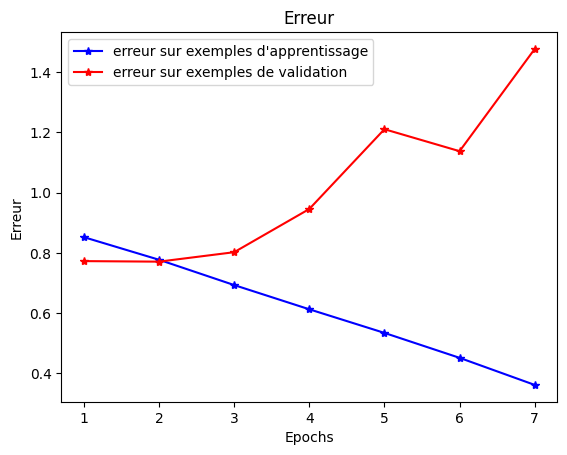

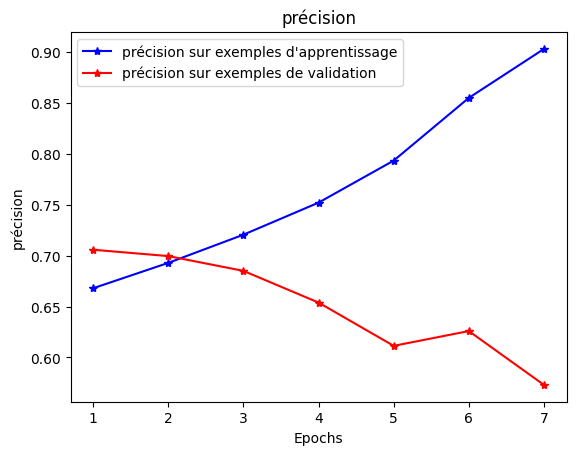

In [290]:
#  définir la structure du réseau
model = Sequential()
model.add(Dense(n_words//3, input_shape=(n_words,), activation='elu'))
model.add(Dense(n_words//27, activation='elu'))
model.add(Dense(n_words//243, activation='elu'))

# Ajout de deux nouvelles couches
model.add(Dense(n_words//729, activation='elu'))
model.add(Dense(n_words//2187, activation='elu'))


#Trois sortie pour label(c'est -1, 0 ou 1)
model.add(Dense(3, activation='softmax'))
# compile network
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

#TODO tester differents nb de tests (epochs)
history = model.fit(xTrain, datas['label'], 
                    validation_split = 0.1,                    
#                    validation_data=(xTest, yTest),
                    batch_size=500,
#                    steps_per_epoch=10,
                    epochs=7, 
                    verbose=2)

history_dict = history.history
history_dict.keys()

import matplotlib.pyplot as plt

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, loss, 'b-*', label='erreur sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_loss, 'r-*', label='erreur sur exemples de validation')
plt.title('Erreur')
plt.xlabel('Epochs')
plt.ylabel('Erreur')
plt.legend()

plt.show()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, acc, 'b-*', label='précision sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_acc, 'r-*', label='précision sur exemples de validation')
plt.title('précision')
plt.xlabel('Epochs')
plt.ylabel('précision')
plt.legend()

plt.show()

Ce réseau de neuronne est en surapprentissage, peut être que sur un jeu de donnée plus grand ou avec de meilleur echantillon en apprentissage nous aurions un bon modèle

# Réseau de neurone n°4 :
Changement de la fonction d'activation

Epoch 1/7
18/18 - 14s - loss: 0.8312 - accuracy: 0.6730 - val_loss: 0.7621 - val_accuracy: 0.7047 - 14s/epoch - 805ms/step
Epoch 2/7
18/18 - 14s - loss: 0.6134 - accuracy: 0.7368 - val_loss: 1.0132 - val_accuracy: 0.6342 - 14s/epoch - 753ms/step
Epoch 3/7
18/18 - 13s - loss: 0.3810 - accuracy: 0.8543 - val_loss: 1.4116 - val_accuracy: 0.5637 - 13s/epoch - 727ms/step
Epoch 4/7
18/18 - 13s - loss: 0.2267 - accuracy: 0.9218 - val_loss: 1.8248 - val_accuracy: 0.5834 - 13s/epoch - 719ms/step
Epoch 5/7
18/18 - 13s - loss: 0.1324 - accuracy: 0.9568 - val_loss: 2.1633 - val_accuracy: 0.5834 - 13s/epoch - 700ms/step
Epoch 6/7
18/18 - 13s - loss: 0.0861 - accuracy: 0.9757 - val_loss: 2.3732 - val_accuracy: 0.5948 - 13s/epoch - 700ms/step
Epoch 7/7
18/18 - 13s - loss: 0.0645 - accuracy: 0.9817 - val_loss: 2.5624 - val_accuracy: 0.5741 - 13s/epoch - 697ms/step


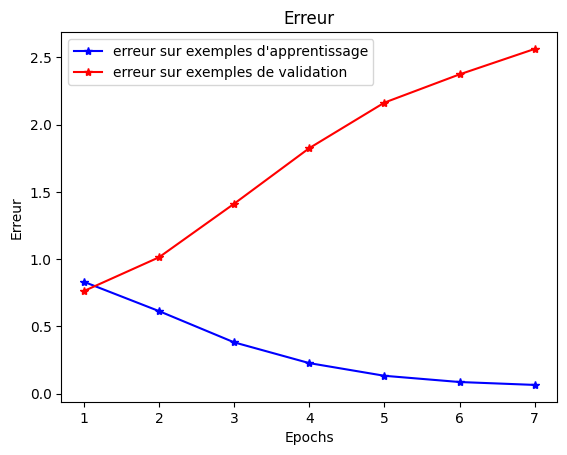

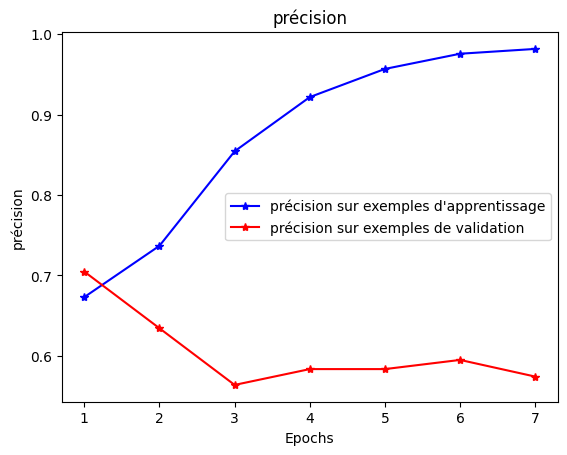

In [291]:
#  définir la structure du réseau
model = Sequential()
model.add(Dense(n_words//3, input_shape=(n_words,), activation='tanh'))
model.add(Dense(n_words//27, activation='tanh'))
model.add(Dense(n_words//243, activation='tanh'))

#Trois sortie pour label(c'est -1, 0 ou 1)
model.add(Dense(3, activation='softmax'))
# compile network
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',  metrics=['accuracy'])

#TODO tester differents nb de tests (epochs)
history = model.fit(xTrain, datas['label'], 
                    validation_split = 0.1,                    
#                    validation_data=(xTest, yTest),
                    batch_size=500,
#                    steps_per_epoch=10,
                    epochs=7, 
                    verbose=2)

history_dict = history.history
history_dict.keys()

import matplotlib.pyplot as plt

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, loss, 'b-*', label='erreur sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_loss, 'r-*', label='erreur sur exemples de validation')
plt.title('Erreur')
plt.xlabel('Epochs')
plt.ylabel('Erreur')
plt.legend()

plt.show()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, acc, 'b-*', label='précision sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_acc, 'r-*', label='précision sur exemples de validation')
plt.title('précision')
plt.xlabel('Epochs')
plt.ylabel('précision')
plt.legend()

plt.show()


Ce réseau de neuronne est en surapprentissage, peut être que sur un jeu de donnée plus grand ou avec de meilleur echantillon en apprentissage nous aurions un bon modèle

# Réseau de neurone n°5 :
Changement de l'optimiseur

Epoch 1/7
18/18 - 7s - loss: 0.9600 - accuracy: 0.6666 - val_loss: 0.8500 - val_accuracy: 0.7057 - 7s/epoch - 403ms/step
Epoch 2/7
18/18 - 6s - loss: 0.8430 - accuracy: 0.6885 - val_loss: 0.8014 - val_accuracy: 0.7057 - 6s/epoch - 346ms/step
Epoch 3/7
18/18 - 6s - loss: 0.8205 - accuracy: 0.6885 - val_loss: 0.7866 - val_accuracy: 0.7057 - 6s/epoch - 351ms/step
Epoch 4/7
18/18 - 6s - loss: 0.8137 - accuracy: 0.6885 - val_loss: 0.7806 - val_accuracy: 0.7057 - 6s/epoch - 350ms/step
Epoch 5/7
18/18 - 7s - loss: 0.8111 - accuracy: 0.6885 - val_loss: 0.7771 - val_accuracy: 0.7057 - 7s/epoch - 404ms/step
Epoch 6/7
18/18 - 7s - loss: 0.8097 - accuracy: 0.6885 - val_loss: 0.7753 - val_accuracy: 0.7057 - 7s/epoch - 383ms/step
Epoch 7/7
18/18 - 7s - loss: 0.8089 - accuracy: 0.6885 - val_loss: 0.7737 - val_accuracy: 0.7057 - 7s/epoch - 387ms/step


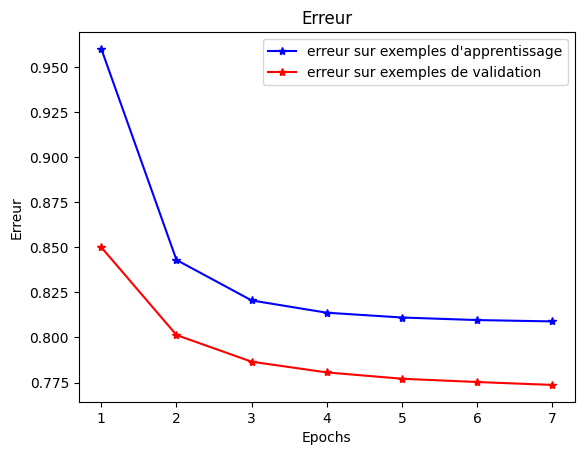

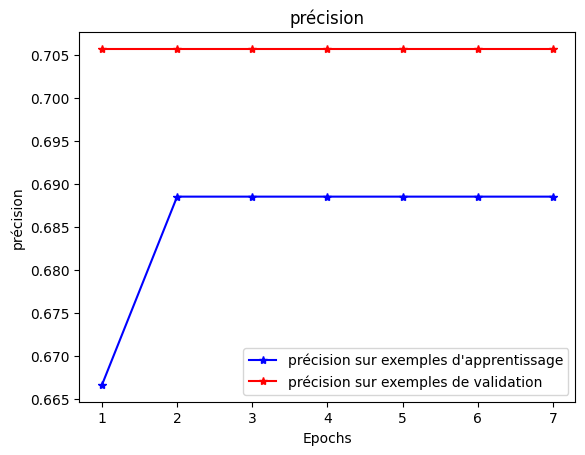

In [292]:
#  définir la structure du réseau
model = Sequential()
model.add(Dense(n_words//3, input_shape=(n_words,), activation='elu'))
model.add(Dense(n_words//27, activation='elu'))
model.add(Dense(n_words//243, activation='elu'))

#Trois sortie pour label(c'est -1, 0 ou 1)
model.add(Dense(3, activation='softmax'))
# compile network
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd',  metrics=['accuracy'])

#TODO tester differents nb de tests (epochs)
history = model.fit(xTrain, datas['label'], 
                    validation_split = 0.1,                    
#                    validation_data=(xTest, yTest),
                    batch_size=500,
#                    steps_per_epoch=10,
                    epochs=7, 
                    verbose=2)

history_dict = history.history
history_dict.keys()

import matplotlib.pyplot as plt

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, loss, 'b-*', label='erreur sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_loss, 'r-*', label='erreur sur exemples de validation')
plt.title('Erreur')
plt.xlabel('Epochs')
plt.ylabel('Erreur')
plt.legend()

plt.show()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, acc, 'b-*', label='précision sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_acc, 'r-*', label='précision sur exemples de validation')
plt.title('précision')
plt.xlabel('Epochs')
plt.ylabel('précision')
plt.legend()

plt.show()

On obtient un modèle viable

# Réseau de neurone n°6 :
Changement de la fonction de calcule d'erreur

Epoch 1/7
18/18 - 12s - loss: 0.1223 - accuracy: 0.3356 - val_loss: 0.0942 - val_accuracy: 0.4249 - 12s/epoch - 663ms/step
Epoch 2/7
18/18 - 11s - loss: 0.1217 - accuracy: 0.3684 - val_loss: 0.0941 - val_accuracy: 0.5461 - 11s/epoch - 615ms/step
Epoch 3/7
18/18 - 11s - loss: 0.1216 - accuracy: 0.3448 - val_loss: 0.0940 - val_accuracy: 0.2715 - 11s/epoch - 607ms/step
Epoch 4/7
18/18 - 11s - loss: 0.1215 - accuracy: 0.3240 - val_loss: 0.0940 - val_accuracy: 0.4383 - 11s/epoch - 607ms/step
Epoch 5/7
18/18 - 11s - loss: 0.1214 - accuracy: 0.3276 - val_loss: 0.0940 - val_accuracy: 0.5523 - 11s/epoch - 610ms/step
Epoch 6/7
18/18 - 11s - loss: 0.1214 - accuracy: 0.3235 - val_loss: 0.0940 - val_accuracy: 0.2933 - 11s/epoch - 607ms/step
Epoch 7/7
18/18 - 11s - loss: 0.1214 - accuracy: 0.3421 - val_loss: 0.0940 - val_accuracy: 0.4404 - 11s/epoch - 602ms/step


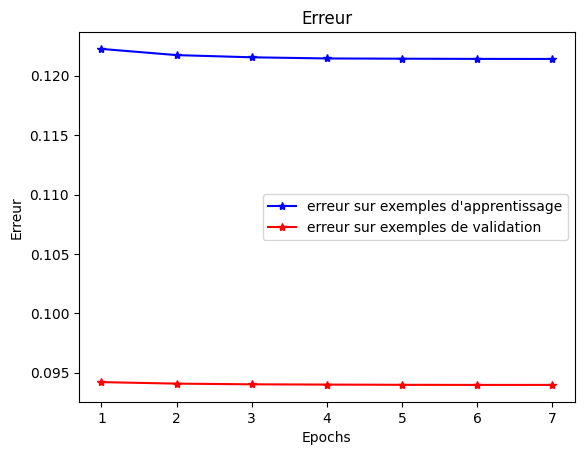

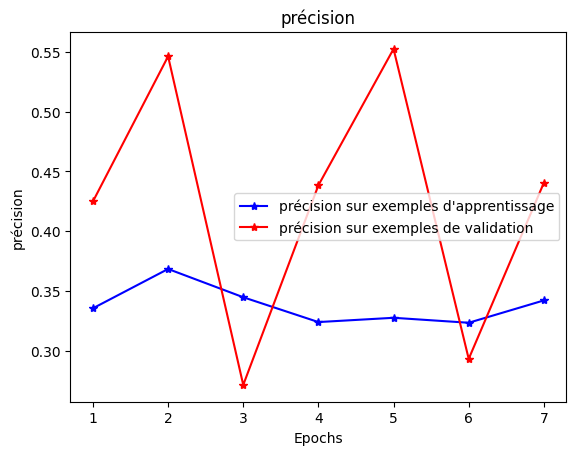

In [294]:
#  définir la structure du réseau
model = Sequential()
model.add(Dense(n_words//3, input_shape=(n_words,), activation='elu'))
model.add(Dense(n_words//27, activation='elu'))
model.add(Dense(n_words//243, activation='elu'))

#Trois sortie pour label(c'est -1, 0 ou 1)
model.add(Dense(3, activation='softmax'))
# compile network
model.compile(loss='categorical_hinge', optimizer='adam',  metrics=['accuracy'])

#TODO tester differents nb de tests (epochs)
history = model.fit(xTrain, datas['label'], 
                    validation_split = 0.1,                    
#                    validation_data=(xTest, yTest),
                    batch_size=500,
#                    steps_per_epoch=10,
                    epochs=7, 
                    verbose=2)

history_dict = history.history
history_dict.keys()

import matplotlib.pyplot as plt

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, loss, 'b-*', label='erreur sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_loss, 'r-*', label='erreur sur exemples de validation')
plt.title('Erreur')
plt.xlabel('Epochs')
plt.ylabel('Erreur')
plt.legend()

plt.show()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

# draw the loss evolution in blue
plt.plot(epochs, acc, 'b-*', label='précision sur exemples d\'apprentissage')
# draw the accuracy evolution in blue
plt.plot(epochs, val_acc, 'r-*', label='précision sur exemples de validation')
plt.title('précision')
plt.xlabel('Epochs')
plt.ylabel('précision')
plt.legend()

plt.show()

On peut voir ici que cette fonction loss n'est pas du tout adapter à notre problème

# Conclusion :
Il faut faire attention au surapprentissage sur ce jeu de donnée
Pour trouver le meilleur modèle de réseau de neuronne on peu changer plusieurs paramètre (nombre de couches, fonction d'activation, calcul d'erreur, optimiseur), il faut faire des essaie pour trouver la meilleur base et ensuite entrainer plusieurs modèle sur cette base, on doit ensuite comparé ses modèle entre eux et garder le meilleur pour obtenir un modèle viable